In [1]:
import numpy as np
import pandas as pd
import glob
import os
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest  import fdrcorrection
from matplotlib.collections import LineCollection
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from scipy.signal import savgol_filter
from scipy import stats
import matplotlib.cm as cm
from pygam import LinearGAM, s, f

In [3]:
from enigmatoolbox.permutation_testing import spin_test, shuf_test

In [4]:
SAaxis = pd.read_csv('/Users/monaminishio/Desktop/HOME38/Functional/modules/Sensorimotor-Association_axis/Sensorimotor_Association_Axis_AverageRanks.csv')

In [5]:
partl = pd.read_csv('/Users/monaminishio/Desktop/HOME38/Functional/derivative/imageData_t1/test/n125_long_inc_part_coef_avg_nodewise_avgrunsschaefer400lh_age.csv')
partr = pd.read_csv('/Users/monaminishio/Desktop/HOME38/Functional/derivative/imageData_t1/test/n125_long_inc_part_coef_avg_nodewise_avgrunsschaefer400rh_age.csv')
part = pd.concat([partl.iloc[:, :-5],partr.iloc[:, :]], axis=1)
H = pd.read_csv('/Users/monaminishio/Desktop/HOME38/Functional/derivative/hurst_exponent/hurst_age.csv')

In [6]:
common = [H.fsid[x] for x in np.arange(H.shape[0]) if H.fsid[x] in part.fsid.values]

In [7]:
realage = pd.read_csv('/Users/monaminishio/Desktop/HOME38/SurfaceArea/dat/t1.csv')
ages = []
for fsid in [H.fsid[x] for x in np.arange(H.shape[0]) if H.fsid[x] in common]:
    ages.append(realage[realage.record_id==fsid.split('-')[1]].age_scan.values[0])

In [8]:
H = H.iloc[[x for x in np.arange(H.shape[0]) if H.fsid[x] in common], :].sort_values('fsid').iloc[:, 1:].reset_index(drop=True)
part = part.iloc[[x for x in np.arange(part.shape[0]) if part.fsid[x] in common], :].sort_values('fsid').reset_index(drop=True)

In [9]:
H['age_scan'] = ages
part['age_scan'] = ages

In [10]:
sa = pd.DataFrame(SAaxis['finalrank.wholebrain'].values).sort_values(0).index.values

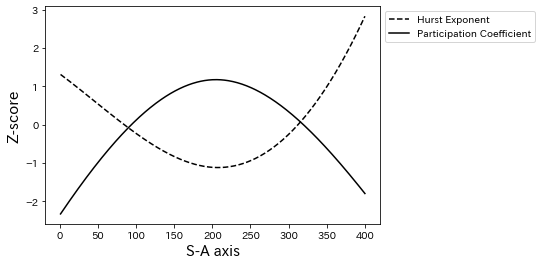

In [11]:
style = ['--', '-']
a = 0
#fig, ax = plt.subplots(1,3,tight_layout=True, figsize=(20,3.5))
for t, df in zip(['Hurst Exponent',  'Participation Coefficient'], [H, part]):
    df_modal = df
    gam = LinearGAM(s(0, n_splines=5)).fit(SAaxis['finalrank.wholebrain'].values,df_modal.iloc[:, :400].mean())
    plt.plot(SAaxis['finalrank.wholebrain'].sort_values().values, stats.zscore(gam.predict(SAaxis['finalrank.wholebrain'].sort_values().values)), style[a], color='k')
    #plt.scatter(np.arange(400), df_modal.iloc[:, :400].mean(),s=5,alpha=0.2, color=cm.Blues(i/max(df.age_bin)))
    plt.legend(['Hurst Exponent', 'Participation Coefficient'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel('S-A axis', size=15)
    plt.ylabel('Z-score', size=15)
    a += 1

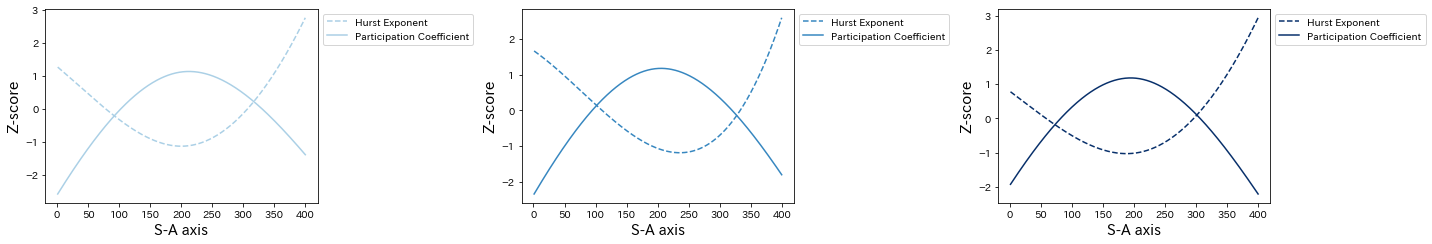

In [12]:
style = ['--', '-']
a = 0
fig, ax = plt.subplots(1,3,tight_layout=True, figsize=(20,3.5))
for t, df in zip(['Hurst Exponent',  'Participation Coefficient'], [H, part]):
    df = df.sort_values('age_scan').reset_index(drop=True)
    df['age_bin'] = [math.floor(x) for x in df.age_scan]
    for z,b in enumerate([[4,5],[6,7],[8,9,10]]):
        bins = [i for i in np.arange(df.shape[0]) if df.age_bin[i] in b]
        df_modal = df.iloc[bins, :]
        gam = LinearGAM(s(0, n_splines=5)).fit(SAaxis['finalrank.wholebrain'].values,df_modal.iloc[:, :400].mean())
        ax[z].plot(SAaxis['finalrank.wholebrain'].sort_values().values, stats.zscore(gam.predict(SAaxis['finalrank.wholebrain'].sort_values().values)), style[a], color=cm.Blues((z+1)/3))
        ax[z].legend(['Hurst Exponent', 'Participation Coefficient'], loc='upper left', bbox_to_anchor=(1, 1))
        ax[z].set_xlabel('S-A axis', size=15)
        ax[z].set_ylabel('Z-score', size=15)
    a += 1

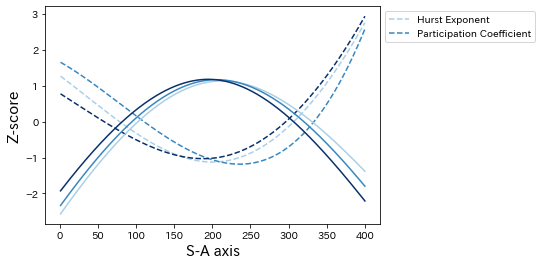

In [13]:
style = ['--', '-']
a = 0
for t, df in zip(['Hurst Exponent',  'Participation Coefficient'], [H, part]):
    df = df.sort_values('age_scan').reset_index(drop=True)
    df['age_bin'] = [math.floor(x) for x in df.age_scan]
    for z,b in enumerate([[4,5],[6,7],[8,9,10]]):
        bins = [i for i in np.arange(df.shape[0]) if df.age_bin[i] in b]
        df_modal = df.iloc[bins, :]
        gam = LinearGAM(s(0, n_splines=5)).fit(SAaxis['finalrank.wholebrain'].values,df_modal.iloc[:, :400].mean())
        plt.plot(SAaxis['finalrank.wholebrain'].sort_values().values, stats.zscore(gam.predict(SAaxis['finalrank.wholebrain'].sort_values().values)), style[a], color=cm.Blues((z+1)/3))
    a += 1
plt.xlabel('S-A axis', size=15)
plt.ylabel('Z-score', size=15)
plt.legend(['Hurst Exponent', 'Participation Coefficient'], loc='upper left', bbox_to_anchor=(1, 1))

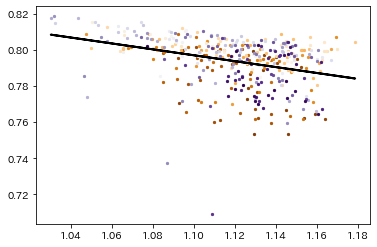

In [14]:
for t,i in enumerate(sa):
    plt.scatter(H.iloc[:, :400].mean()[i], part.iloc[:, :400].mean()[i], s=5, color=sns.color_palette('PuOr', n_colors=len(np.arange(400))).as_hex()[t])
df_x = pd.DataFrame(H.iloc[:, :400].mean())
df_y = pd.DataFrame(part.iloc[:, :400].mean())
mod = LinearRegression()
mod_lin = mod.fit(df_x, df_y)
y_lin_fit = mod_lin.predict(df_x)
r2_lin = mod.score(df_x, df_y)
plt.plot(df_x, y_lin_fit, color = '#000000', linewidth=2)

In [16]:
# spin-test
fc_ctx_p, fc_ctx_d = spin_test(H.iloc[:, :400].mean(), part.iloc[:, :400].mean(), surface_name='fsa5', parcellation_name='aparc',type='pearson', n_rot=1000, null_dist=True)
print(fc_ctx_p)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
0.0365


permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
0.0435
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
0.013999999999999999
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
0.5934999999999999


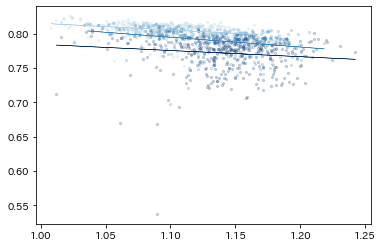

In [18]:
H['age_bin'] = [math.floor(x) for x in H.age_scan]
part['age_bin'] = [math.floor(x) for x in part.age_scan]
for z,b in enumerate([[4,5],[6,7],[8,9,10]]):
    bins = [i for i in np.arange(H.shape[0]) if H.age_bin[i] in b]
    plt.scatter(H.iloc[bins, :400].mean(),part.iloc[bins, :400].mean(), s=5, color= cm.Blues((z+1)/3), alpha=0.2)
    df_x = pd.DataFrame(H.iloc[bins, :400].mean())
    df_y = pd.DataFrame(part.iloc[bins, :400].mean())
    mod = LinearRegression()
    mod_lin = mod.fit(df_x, df_y)
    y_lin_fit = mod_lin.predict(df_x)
    r2_lin = mod.score(df_x, df_y)
    plt.plot(df_x, y_lin_fit, linewidth=0.5, color=cm.Blues((z+1)/3))
    fc_ctx_p, fc_ctx_d = spin_test(H.iloc[bins, :400].mean(), part.iloc[bins, :400].mean(), surface_name='fsa5', parcellation_name='aparc',type='pearson', n_rot=1000, null_dist=True)
    print(fc_ctx_p)